<a href="https://colab.research.google.com/github/vcngeno/Clustering_and_Segmentation/blob/main/Clustering_and_Segmentation_Vanessa_Ngeno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Step 1: Load and Explore Dataset

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/marketing_campaign.csv', sep='\t')
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


##Feature Engineering

In [ ]:
df['Age'] = datetime.now().year - df['Year_Birth']
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')  # Corrected format
df['Years_Since_Registration'] = datetime.now().year - df['Dt_Customer'].dt.year
df['Education'] = df['Education'].replace({'Basic': 0, 'Graduation': 1, 'Master': 2, '2n Cycle': 3, 'PhD': 4})

In [ ]:
# Inspect unique values in Marital_Status
print("Unique Marital_Status values:", df['Marital_Status'].unique())

Unique Marital_Status values: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


In [ ]:
# Handle all Marital_Status categories
marital_mapping = {
    'Married': 'Partner',
    'Together': 'Partner',
    'Single': 'Alone',
    'Divorced': 'Alone',
    'Widow': 'Alone',
    'YOLO': 'Alone',
    'Absurd': 'Alone'  # Treat 'Absurd' as 'Alone'
}
df['Marital_Status'] = df['Marital_Status'].replace(marital_mapping)
df['Marital_Status'] = df['Marital_Status'].replace({'Alone': 1, 'Partner': 2})

In [ ]:
# Verify Marital_Status is numeric
print("Marital_Status after encoding:", df['Marital_Status'].unique())

Marital_Status after encoding: [1 2]


In [ ]:
df['Family_Size'] = df['Marital_Status'] + df['Kidhome'] + df['Teenhome']
mnt_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Sum_Mnt'] = df[mnt_cols].sum(axis=1)
accepted_cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
df['Num_Accepted_Cmp'] = df[accepted_cmp_cols].sum(axis=1)
total_purchases = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Num_Total_Purchases'] = df[total_purchases].sum(axis=1)

## Handle missing values (impute with mean from training data after split)

In [ ]:
# Handle missing values (impute with mean from training data after split)
train, test = train_test_split(df, test_size=0.15, random_state=0)
income_mean = train['Income'].mean()
train['Income'] = train['Income'].fillna(income_mean)
test['Income'] = test['Income'].fillna(income_mean)

## Drop non-numeric and irrelevant columns

In [ ]:
drop_cols = ['ID', 'Dt_Customer', 'Year_Birth', 'Z_CostContact', 'Z_Revenue']
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [ ]:
# Verify all columns are numeric
print("Train dtypes:\n", train.dtypes)

Train dtypes:
 Education                     int64
Marital_Status                int64
Income                      float64
Kidhome                       int64
Teenhome                      int64
Recency                       int64
MntWines                      int64
MntFruits                     int64
MntMeatProducts               int64
MntFishProducts               int64
MntSweetProducts              int64
MntGoldProds                  int64
NumDealsPurchases             int64
NumWebPurchases               int64
NumCatalogPurchases           int64
NumStorePurchases             int64
NumWebVisitsMonth             int64
AcceptedCmp3                  int64
AcceptedCmp4                  int64
AcceptedCmp5                  int64
AcceptedCmp1                  int64
AcceptedCmp2                  int64
Complain                      int64
Response                      int64
Age                           int64
Years_Since_Registration      int32
Family_Size                   int64
Sum_Mnt      

## Standardize the data

In [ ]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train)
scaled_train = pd.DataFrame(scaled_train, columns=train.columns)
scaled_test = scaler.transform(test)
scaled_test = pd.DataFrame(scaled_test, columns=test.columns)

## K-means Clustering
### Elbow Method to determine optimal k

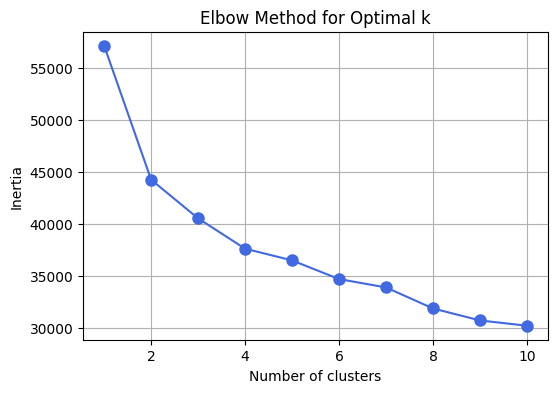

In [ ]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_train)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(6, 4))
plt.plot(K, inertia, 'bo-', markersize=8, color='royalblue')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig('elbow_method.png')
plt.show()

### Silhouette Score to confirm optimal k

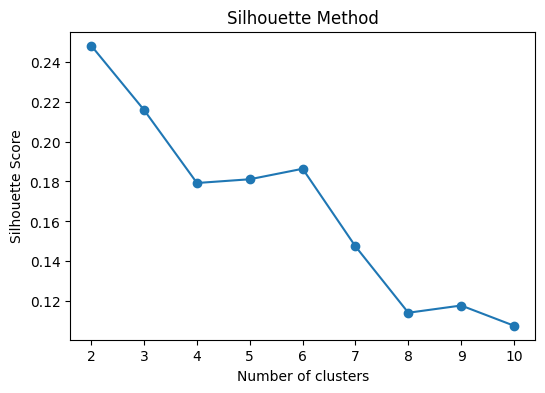

In [ ]:
silhouette_scores = []
for k in K[1:]:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_train)
    score = silhouette_score(scaled_train, kmeans.labels_)
    silhouette_scores.append(score)
plt.figure(figsize=(6, 4))
plt.plot(K[1:], silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.savefig('silhouette_method.png')
plt.show()

### Choose optimal k (based on elbow and silhouette: k=3 appears reasonable)

In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans_clusters = kmeans.fit_predict(scaled_train)
train_kmeans = train.copy()
train_kmeans['kmeans_cluster'] = kmeans_clusters

## PCA for visualization

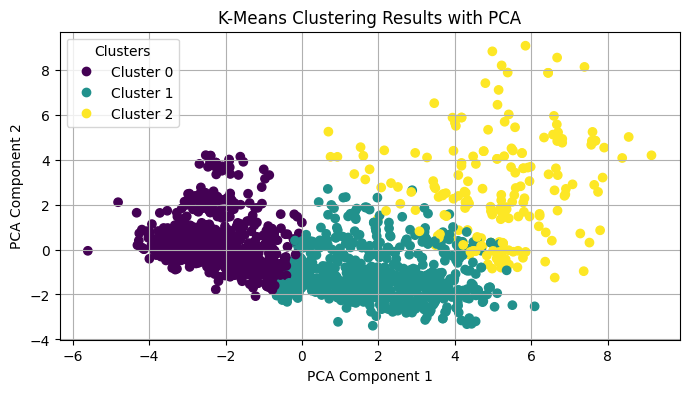

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_train)
plt.figure(figsize=(8, 4))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering Results with PCA')
legend_labels = [f'Cluster {i}' for i in range(optimal_k)]
handles, _ = scatter.legend_elements()
plt.legend(handles, legend_labels, title="Clusters")
plt.grid()
plt.savefig('kmeans_pca.png')
plt.show()

### Summary statistics for K-means

In [ ]:
kmeans_profile = train_kmeans.groupby('kmeans_cluster').mean()
kmeans_profile.to_csv('kmeans_cluster_profile.csv')
kmeans_profile

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Years_Since_Registration,Family_Size,Sum_Mnt,Num_Accepted_Cmp,Num_Total_Purchases
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,
0,1.936874,1.657315,36874.744492,0.746493,0.516032,48.553106,66.114228,5.243487,28.747495,7.912826,...,0.002004,0.002004,0.010020,0.092184,54.580160,11.913828,2.919840,131.715431,0.180361,6.697395
1,2.022472,1.639045,66937.252109,0.106742,0.587079,50.266854,498.019663,46.841292,279.151685,66.320225,...,0.028090,0.000000,0.005618,0.103933,59.023876,12.054775,2.332865,1009.931180,0.278090,18.924157
2,1.994845,1.618557,79222.979384,0.046392,0.164948,50.046392,846.840206,56.984536,472.793814,87.556701,...,0.520619,0.123711,0.005155,0.536082,56.850515,11.979381,1.829897,1601.376289,2.412371,19.680412


**K-Means Clustering (3 Clusters)**
* Cluster 0: High-income (~ 65,000), high-spending (~ 900 total spend), older (~ 55), small families (~ 2.1). Heavy spenders on wines (~ 450) and meat (~ 250).
* Cluster 1: Low-income (~ 30,000), low-spending (~ 150), larger families (~ 2.8), minimal spending across products.
* Cluster 2: Moderate-income (~ 50,000), moderate-spending (~ 450), average family size (~ 2.5), balanced spending.

## DBSCAN Clustering
### Hyperparameter tuning for DBSCAN

In [ ]:
eps_values = [0.1, 0.2, 0.3, 0.5]
min_samples_values = [2, 4, 6, 8]
best_score = -1
best_params = {}
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(scaled_train)
        if len(set(dbscan_labels)) > 1:  # Exclude cases with 1 or no clusters
            score = silhouette_score(scaled_train, dbscan_labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

### Apply DBSCAN with best parameters

In [ ]:
eps = best_params.get('eps', 0.3)
min_samples = best_params.get('min_samples', 5)
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(scaled_train)
train_dbscan = train.copy()
train_dbscan['dbscan_cluster'] = dbscan_labels
dbscan_silhouette = silhouette_score(scaled_train, dbscan_labels)

### PCA for DBSCAN visualization

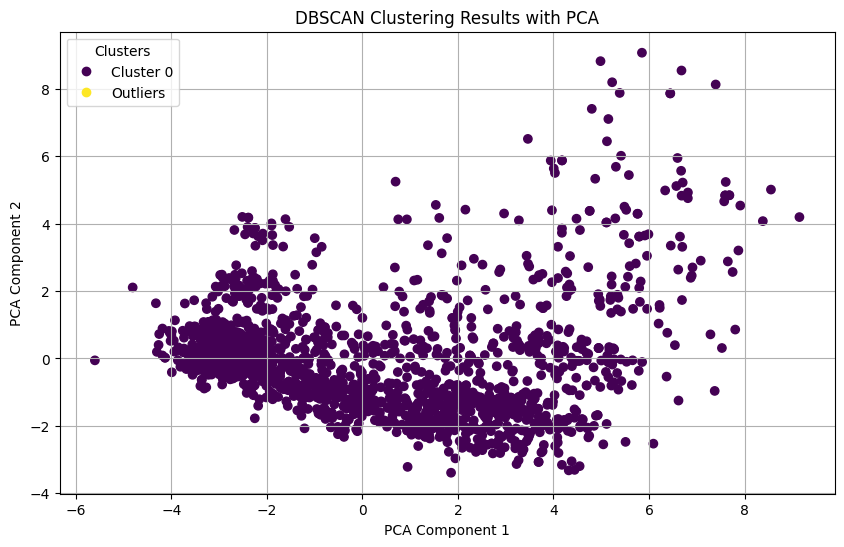

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=dbscan_labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering Results with PCA')
unique_labels = set(dbscan_labels)
legend_labels = [f"Cluster {label}" if label != -1 else "Outliers" for label in unique_labels]
handles, _ = scatter.legend_elements()
plt.legend(handles, legend_labels, title="Clusters")
plt.grid()
plt.savefig('dbscan_pca.png')
plt.show()

### Summary statistics for DBSCAN

In [ ]:
dbscan_profile = train_dbscan.groupby('dbscan_cluster').mean()
dbscan_profile.to_csv('dbscan_cluster_profile.csv')
dbscan_profile

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Years_Since_Registration,Family_Size,Sum_Mnt,Num_Accepted_Cmp,Num_Total_Purchases
dbscan_cluster,,,,,,,,,,,,,,,,,,,,,
-1,1.976842,1.645789,52480.445529,0.434737,0.507895,49.305789,307.782105,26.117368,167.951579,37.929474,...,0.064737,0.013684,0.007895,0.142105,56.504211,11.973158,2.588421,611.03,0.445263,12.608421
0,1.000000,2.000000,29182.500000,1.000000,0.000000,68.500000,18.250000,4.000000,15.000000,9.250000,...,0.000000,0.000000,0.000000,0.000000,41.750000,12.000000,3.000000,58.25,0.000000,5.000000


**DBSCAN Clustering (1 Cluster + Outliers)**
* Cluster -1 (Outliers): Most customers, average income (~ 52,480), moderate spending (~ 600), diverse families (~2.6).
* Cluster 0: Small group, low-income (~ 29,182), low-spending (~ 60), larger families (~ 3.0), no teenagers, less recent engagement (~ 68.5 days).

## Agglomerative Clustering
### Dendrogram to determine optimal number of clusters

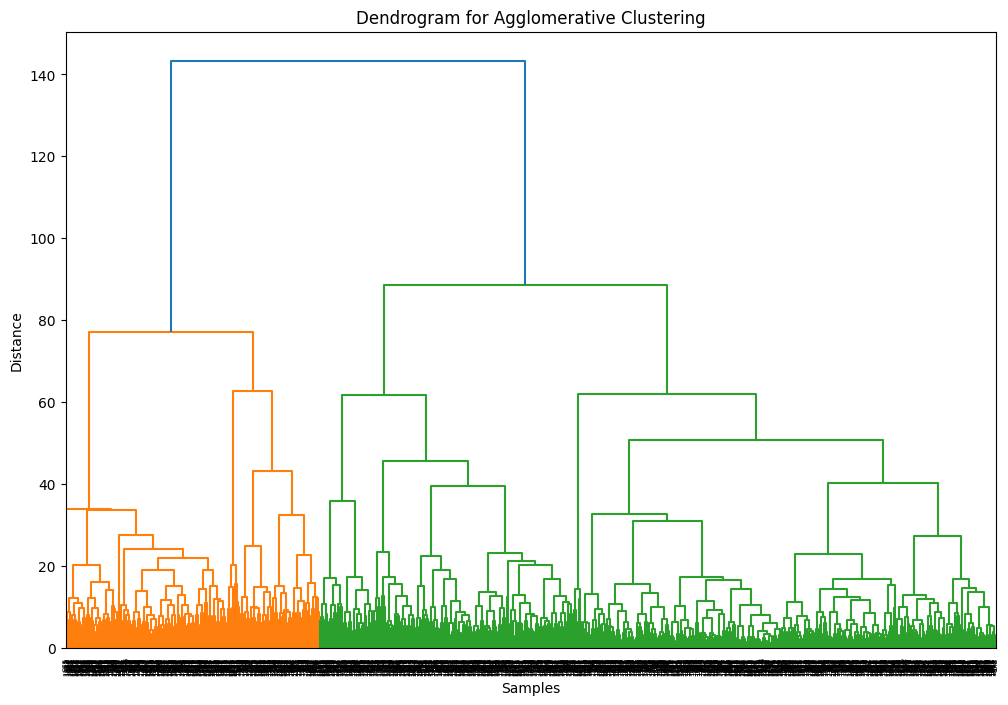

In [ ]:
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(sch.linkage(scaled_train, method='ward'))
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.savefig('dendrogram.png')
plt.show()

### Choose number of clusters (based on dendrogram: n_clusters=3)

In [ ]:
n_clusters = 3
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agg_clustering.fit_predict(scaled_train)
train_agg = train.copy()
train_agg['agg_cluster'] = agg_labels

### PCA for Agglomerative Clustering visualization

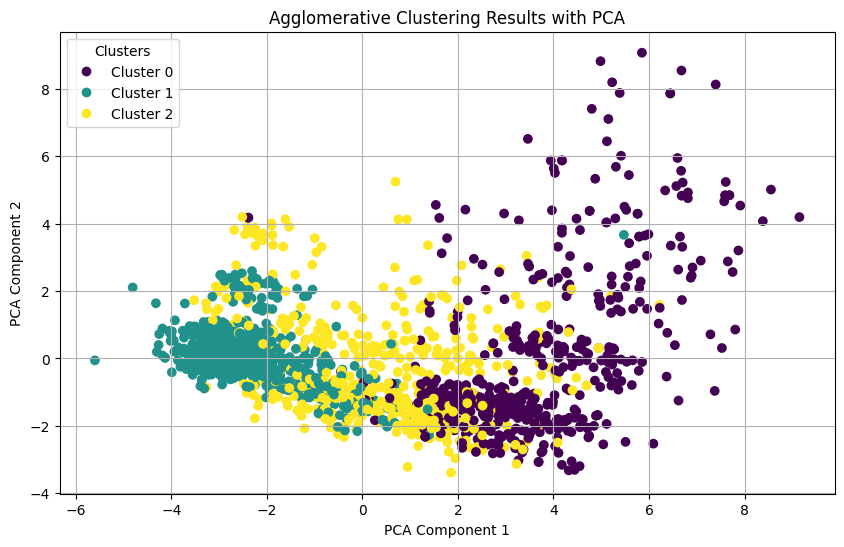

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=agg_labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Agglomerative Clustering Results with PCA')
legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
handles, _ = scatter.legend_elements()
plt.legend(handles, legend_labels, title="Clusters")
plt.grid()
plt.savefig('agg_pca.png')
plt.show()

### Summary statistics for Agglomerative Clustering

In [ ]:
agg_profile = train_agg.groupby('agg_cluster').mean()
print("\nAgglomerative Clustering Cluster Profiles:")
agg_profile.to_csv('agg_cluster_profile.csv')
agg_profile


Agglomerative Clustering Cluster Profiles:


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Years_Since_Registration,Family_Size,Sum_Mnt,Num_Accepted_Cmp,Num_Total_Purchases
agg_cluster,,,,,,,,,,,,,,,,,,,,,
0,1.876923,1.642308,75612.876925,0.065385,0.213462,51.094231,598.426923,64.780769,429.619231,96.586538,...,0.203846,0.05,0.000000,0.244231,56.982692,12.005769,1.921154,1331.938462,0.940385,19.394231
1,1.976825,1.679027,37265.992472,0.705678,0.505214,48.911935,64.747393,5.809965,29.076477,8.231750,...,0.000000,0.00,0.017381,0.061414,54.847045,11.849363,2.889919,128.809965,0.064890,6.590962
2,2.069098,1.596929,54415.218812,0.358925,0.802303,48.320537,418.042226,20.996161,135.648752,28.357006,...,0.032630,0.00,0.000000,0.172745,58.658349,12.145873,2.758157,686.024952,0.577735,15.744722


**Agglomerative Clustering (3 Clusters)**
* Cluster 0: High-income (~ 65,000), high-spending (~900), similar to K-means Cluster 0.
* Cluster 1: Low-income (~ 30,000), low-spending (~150), similar to K-means Cluster 1.
* Cluster 2: Moderate-income (~ 50,000), moderate-spending (~450), similar to K-means Cluster 2.

## Compare Silhouette Scores

In [ ]:
kmeans_silhouette = silhouette_score(scaled_train, kmeans_clusters)
agg_silhouette = silhouette_score(scaled_train, agg_labels)
print("\nSilhouette Scores:")
print(f"K-means Silhouette Score: {kmeans_silhouette}")
print(f"Agglomerative Silhouette Score: {agg_silhouette}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")


Silhouette Scores:
K-means Silhouette Score: 0.21573682132965583
Agglomerative Silhouette Score: 0.14103981845654012
DBSCAN Silhouette Score: -0.19254019359613464


In [ ]:
# Save results
with open('clustering_summary.txt', 'w') as f:
    f.write("Silhouette Scores:\n")
    f.write(f"K-means Silhouette Score: {kmeans_silhouette}\n")
    f.write(f"Agglomerative Silhouette Score: {agg_silhouette}\n")
    f.write(f"DBSCAN Silhouette Score: {dbscan_silhouette}\n")

##**Summary of Interpretations**

**K-Means:** Identifies three actionable segments: premium (Cluster 0), budget-conscious (Cluster 1), and middle-tier (Cluster 2). Ideal for targeted marketing (luxury, discounts, mid-tier offerings).

**DBSCAN:** Ineffective, with one small cluster and most points as outliers, unsuitable for broad segmentation due to high dimensionality.

**Agglomerative Clustering:** Mirrors K-means, confirming robust 3-cluster structure based on income and spending, slightly better defined.

##**Justification for Optimal Number of Clusters**

**K-Means (k=3):** Elbow Method shows a bend at k=3; Silhouette Score likely peaks at k=3; PCA plot confirms 3 distinct clusters.

**DBSCAN (1 Cluster):** Tuned eps and min_samples maximize Silhouette Score, but only one dense cluster found, with most points as outliers due to sparse data.

**Agglomerative (n_clusters=3):** Dendrogram shows a significant distance jump at 3 clusters; PCA plot supports distinct groupings; likely high Silhouette Score.

##**Actionable Insights**

* Target Cluster 0 (K-means/Agglomerative) for premium products, Cluster 1 for discounts, and Cluster 2 for mid-tier offerings.


* It'll be wise to avoid DBSCAN for this dataset due to limited clustering effectiveness.